<a href="https://colab.research.google.com/github/Gus-1003/ISD-invention/blob/main/Pesquisa/5_Valida%C3%A7%C3%A3o_Modularizada.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importando Bibliotecas

In [1]:
import os

import glob

import cv2

import numpy as np

import math

import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns

from google.colab.patches import cv2_imshow

from google.colab import drive

drive.mount('/content/drive/')

%cd /content/drive/MyDrive/

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/MyDrive


# Funções:

## Calcular_Distancia

In [2]:
def calcular_distancia(x1, y1, x2, y2):
  # Calcula a diferença entre as coordenadas x e y
  diff_x = x2 - x1
  diff_y = y2 - y1

  # Calcula o quadrado das diferenças
  diff_x_squared = diff_x ** 2
  diff_y_squared = diff_y ** 2

  # Calcula a soma dos quadrados das diferenças
  sum_diff_squared = diff_x_squared + diff_y_squared

  # Calcula a raiz quadrada da soma dos quadrados das diferenças
  distancia = math.sqrt(sum_diff_squared)

  return distancia

## Create_Dataset:

In [3]:
def create_dataset_image(dataset):
  # Cria uma lista vazia para armazenar os objetos
  objects = []

  # Percorre o dicionário
  for attr, obj_list in dataset.items():
    # Percorre a lista de objetos para o atributo atual
    for obj in obj_list:
      # Verifica se obj é um dicionário
      if isinstance(obj, dict):
        # Adiciona o objeto combinando com o dicionário {'attribute': attr}
        objects.append({**{'attribute': attr}, **obj})

  # Cria o DataFrame com base na lista de objetos
  df = pd.DataFrame(objects)

  # Retorna o DataFrame se for necessário usá-lo posteriormente
  return df

## calculate_contour_properties:

In [4]:
def calculate_contour_properties(cnt):
  # Momentos do objeto
  M = cv2.moments(cnt)

  # Calcula a área do contorno
  area = cv2.contourArea(cnt)

  # Calcula o perímetro do contorno
  perimeter = cv2.arcLength(cnt, True)

  # Proporção de aspecto do objeto
  x,y,w,h = cv2.boundingRect(cnt)
  width = w
  height = h

  if min(w, h) == 0:
    aspect_ratio = 0
  else:
    aspect_ratio = max(float(w), h) / min(float(w), h)

  # Ângulo e raio mínimo envolvente em torno do objeto
  rect = cv2.minAreaRect(cnt)
  circle = cv2.minEnclosingCircle(cnt)

  box = cv2.boxPoints(rect)
  box = np.int0(box)

  # Extensão do objeto (razão entre a área do objeto e a área do retângulo envolvente mínimo)
  rect_area = w*h

  # Forma de achar o contorno 1
  center_x = int(M["m10"] / M["m00"])
  center_y = int(M["m01"] / M["m00"])

  # Forma de achar o contorno 2 - Circulo
  (x_circle, y_circle), radius = cv2.minEnclosingCircle(cnt)
  center_circle = (int(x_circle), int(y_circle))
  cx_circle = int(x_circle)
  cy_circle = int(y_circle)

  # Forma de achar o contorno 2 - Quadrado
  cx_quad = int(x)
  cy_quad = int(y)

  # Calcula a circularidade do contorno
  if perimeter > 0:
      circularity = 4 * np.pi * area / (perimeter ** 2)
  else:
      circularity = 0
      
  return area, circularity, radius, x, y, w, h, aspect_ratio, box, center_circle, cx_circle, cy_circle, cx_quad, cy_quad, center_x, center_y

## process_contours:

In [5]:
def process_contours(nome_frame, img_contours, contours, imagem_original):

  objetos = 0
  dicionario = {}  # Dicionário para armazenar os dados dos objetos identificados

  for cnt in contours:
    # Aproxima o contorno por uma sequência de segmentos de linha
    approx = cv2.approxPolyDP(cnt, 0.01 * cv2.arcLength(cnt, True), True)

    # Calcula as propriedades do contorno
    area, circularity, radius, x, y, w, h, aspect_ratio, box, center, cx_circle, cy_circle, cx_quad, cy_quad, center_x, center_y = calculate_contour_properties(cnt)

    x1 = 227
    y1 = 352

    if objetos == 1:
      x1 = 373
      y1 = 354


    # Para um padrão Circular:
    if circularity > 0.30 and area > 2000 and radius < 100 and radius > 20:

      # Define o raio máximo desejado
      max_radius = 100

      # Limita o raio ao valor máximo
      radius = min(radius, max_radius)

      # Converte o raio para inteiro
      radius = int(radius)

      # Calcula as Distancias entre os pontos centrais
      distance_green_blue = calcular_distancia(cx_circle, cy_circle, center_x, center_y)

      # Calcula as Distancias entre os pontos centrais
      distance_red_blue = calcular_distancia(x1, y1, center_x, center_y)
      distance_red_green = calcular_distancia(x1, y1, cx_circle, cy_circle)

      # Desenha um contorno Circular
      cv2.circle(img_contours, center, radius, (0, 255, 0), 2)
      
      # Desenho do ponto central
      cv2.circle(img_contours, (cx_circle, cy_circle), 3, (0, 255, 0), -1) # Verde - minEnclosingCircle
      cv2.circle(img_contours, (center_x, center_y), 3, (255, 0, 0), -1) # Azul - Momentun

      # Desenha uo ponto central ideal
      cv2.circle(img_contours, (x1, y1), 3, (0, 0, 255), -1) # Vermelho - Ideal

      # Contagem total de Objetos Identificados
      objetos = objetos + 1

      # Captura dos dados:
      dicionario[f"{nome_frame}_{objetos}"] = []
      # Adicione os dados desejados ao dicionário dataset
      dicionario[f"{nome_frame}_{objetos}"].append({
        "Form": "circle",
        "area": area,
        "circularity": circularity,
        "radius": radius,
        "x": x,
        "y": y,
        "w": w,
        "h": h,
        "cx_circle": cx_circle,
        "cy_circle": cy_circle,
        "cx_momentun": center_x,
        "cy_momentun": center_y,
        "cx_vermelho": x1,
        "cy_vermelho": y1,
        "distance_green_blue" : distance_green_blue,
        "distance_red_blue" : distance_red_blue,
        "distance_red_green" : distance_red_green,
      })


    else:
      if aspect_ratio < 2 and area > 2000 and area < 6543.5 and radius < 100: 
        # Calcula as Distancias entre os pontos centrais
        distance_green_blue = calcular_distancia(cx_circle, cy_circle, center_x, center_y)

        # Calcula as Distancias entre os pontos centrais
        distance_red_blue = calcular_distancia(x1, y1, center_x, center_y)
        distance_red_green = calcular_distancia(x1, y1, cx_circle, cy_circle)

        # Desenha um contorno quadratico
        cv2.drawContours(img_contours, [box], 0, (0, 255, 0), 2)

        # Desenho do ponto central
        cv2.circle(img_contours, (cx_circle, cy_circle), 3, (0, 255, 0), -1) # verde - minEnclosingCircle
        cv2.circle(img_contours, (center_x, center_y), 3, (255, 0, 0), -1) # Azul - Momentun
        
        # Desenha uo pont0 central ideal
        cv2.circle(img_contours, (x1, y1), 3, (0, 0, 255), -1) # Vermelho - Ideal

        # Contagem total de Objetos Identificados
        objetos = objetos + 1
        dicionario[f"{nome_frame}_{objetos}"] = []
        dicionario[f"{nome_frame}_{objetos}"].append({
          "Form": "Não Circular",
          "area": area,
          "circularity": circularity,
          "radius": radius,
          "x": x,
          "y": y,
          "w": w,
          "h": h,
          "cx_circle": cx_circle,
          "cy_circle": cy_circle,
          "cx_momentun": center_x,
          "cy_momentun": center_y,
          "cx_vermelho": x1,
          "cy_vermelho": y1,
          "distance_green_blue" : distance_green_blue,
          "distance_red_blue" : distance_red_blue,
          "distance_red_green" : distance_red_green,
        })

  return imagem_original, objetos, dicionario

## find_contours:

In [6]:
def find_contours(image):
  # Encontra os contornos na imagem
  contours, hierarchy = cv2.findContours(image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  return contours

## dilate_image:

In [7]:
def dilate_image(image):
  # Define o kernel para a dilatação
  kernel = np.ones((5, 5), np.uint8)

  # Dilata a imagem
  image = cv2.dilate(image, kernel, iterations=2)
  return image

## apply_threshold:

In [8]:
def apply_threshold(image):
  # Aplica um filtro de Sobel em x e y
  sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
  sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)

  # Calcula a magnitude do gradiente
  gradient_magnitude = cv2.magnitude(sobelx, sobely)

  # Normaliza a magnitude do gradiente
  gradient_magnitude = cv2.normalize(gradient_magnitude, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)

  # Aplica uma limiarização utilizando o método de Otsu
  _, gradient_threshold = cv2.threshold(gradient_magnitude, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
  
  return gradient_threshold

## apply_filters:

In [9]:
def apply_filters(image):
  # Converte a imagem para float32
  image32f = np.float32(image)
  
  # Aplica um filtro de média
  mu = cv2.blur(image32f, (3, 3))

  # Calcula a variância da imagem filtrada
  mu2 = cv2.blur(image32f * image32f, (3, 3))
  sigma = cv2.sqrt(mu2 - mu * mu)
  sigma = sigma * 10
  sigma = sigma.astype("uint8")

  # Aplica um filtro de borramento Gaussiano
  sigma = cv2.GaussianBlur(sigma, (5, 5), 0)

  # Aplica o filtro Laplaciano
  laplacian = cv2.Laplacian(sigma, cv2.CV_32F)

  # Converte a saída para o intervalo de 0 a 255
  sigma = cv2.convertScaleAbs(laplacian)

  return sigma

## print_frame_info:

In [10]:
def print_frame_info(nome):
  # Imprime informações do frame
  print(f"================================================================================")
  print(f"================================================================================")
  print(f"Amostra: " + nome)

## process_frame:

In [11]:
def process_frame(frame):
  # Carrega a imagem
  im = cv2.imread(frame)
  
  # Divide o caminho do arquivo e obtém o nome do frame
  nome_completo = frame.split('/')
  nome = nome_completo[int(posicao_do_nome_frame)].split('.')
  amostra = nome[0]

  # Imprime informações do frame
  print_frame_info(amostra)

  # Cria uma cópia da imagem para desenhar os contornos
  img_contours = im.copy()

  # Converte a imagem para escala de cinza
  image = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

  # Aplica uma série de filtros à imagem
  sigma = apply_filters(image)

  # Aplica uma limiarização à imagem filtrada
  gradient_threshold = apply_threshold(sigma)

  # Dilata a imagem limiarizada
  gradient_threshold = dilate_image(gradient_threshold)

  # Encontra os contornos na imagem dilatada
  contours = find_contours(gradient_threshold)

  # Processa cada contorno encontrado
  resultados = process_contours(amostra, img_contours, contours, img_contours)

  return resultados, amostra

# Base do Sistema:

## Endereço da imagem:

In [12]:
destino = '/content/drive/MyDrive/Pesquisa_ISD_IC/Validação/'

### Imagem Alvo:

In [13]:
frame = '/content/drive/MyDrive/Pesquisa_ISD_IC/Validação/Dia5-TTD-CCM549-Contexto2.jpg'

In [14]:
posicao_do_nome_frame = 6

# Algoritmo Principal:

Amostra: Dia5-TTD-CCM549-Contexto2
2


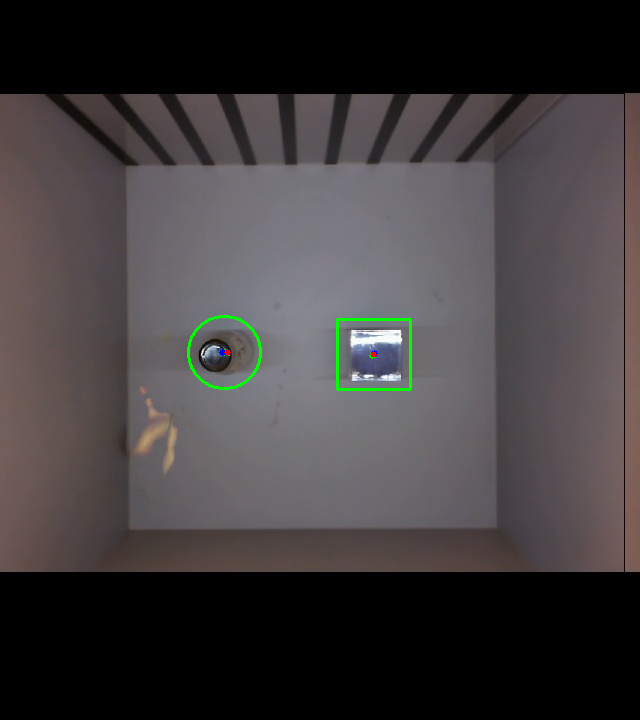

In [15]:
resultados, amostra = process_frame(frame)

# Imprime o número de objetos encontrados
print(resultados[1])

# Exibe a imagem com os contornos encontrados
cv2_imshow(resultados[0])

output_path = os.path.join(destino, f"{amostra}_bteste.jpg")

# Salvar a imagem resultante
cv2.imwrite(output_path, resultados[0])

# Chama a função create_dataset com o dataset gerado
dados = create_dataset_image(resultados[2])

output_path_data = os.path.join(destino, f"{amostra}_data.csv")

# Salva o DataFrame em um arquivo CSV
dados.to_csv(output_path_data, index=False)

In [16]:
resultados[0].shape

(720, 640, 3)

As duas representações estão invertendo a ordem das dimensões da imagem em relação a altura e largura.

No caso da notação "Python: (480, 640, 3)", os valores representam:

480: A altura da imagem em pixels.
640: A largura da imagem em pixels.
3: O número de canais de cores da imagem (normalmente, vermelho, verde e azul).
Na notação "ImageJ: (640, 480, 3)", ocorre a inversão das dimensões, então temos:

640: A largura da imagem em pixels.
480: A altura da imagem em pixels.
3: O número de canais de cores da imagem.
A diferença entre as ordens das dimensões pode ocorrer por diferentes convenções adotadas pelos softwares ou bibliotecas ao representar a imagem. É importante observar que a ordem das dimensões não afeta o conteúdo visual da imagem, apenas a forma como ela é interpretada e exibida pelos programas.

# Mineração dos Dados:

In [17]:
dados

,attribute,Form,area,circularity,radius,x,y,w,h,cx_circle,cy_circle,cx_momentun,cy_momentun,cx_vermelho,cy_vermelho,distance_green_blue,distance_red_blue,distance_red_green
0,Dia5-TTD-CCM549-Contexto2_1,circle,2917.5,0.406092,36.000000,190,321,69,62,224,352,222,352,227,352,2.000000,5.000000,3.000000
1,Dia5-TTD-CCM549-Contexto2_2,Não Circular,3881.0,0.290981,45.703087,337,319,74,71,372,355,374,353,373,354,2.828427,1.414214,1.414214


In [19]:
# Lista para armazenar os DataFrames de cada arquivo CSV
dataframes = []

# Percorre todos os arquivos na pasta
for arquivo in os.listdir(destino):
    if arquivo.endswith('.csv'):
        # Caminho completo para o arquivo CSV
        caminho_arquivo = os.path.join(destino, arquivo)
        
        # Carrega o arquivo CSV como DataFrame
        df = pd.read_csv(caminho_arquivo)
        
        # Adiciona o DataFrame à lista
        dataframes.append(df)

# Concatena todos os DataFrames em um único DataFrame
dataset_geral = pd.concat(dataframes, ignore_index=True)

# Salva o DataFrame em um arquivo CSV
dataset_geral.to_csv(destino + 'dataset_geral.csv', index=False)

In [20]:
dataset_geral.head()

,attribute,Form,area,circularity,radius,x,y,w,h,cx_circle,cy_circle,cx_momentun,cy_momentun,cx_vermelho,cy_vermelho,distance_green_blue,distance_red_blue,distance_red_green
0,Dia2-Explo-CCM539-Contexto1_1,circle,7418.0,0.784758,51.0,718,316,96,97,764,363,764,363.0,764,361,0.000000,2.000000,2.000000
1,Dia2-Explo-CCM539-Contexto1_2,circle,6854.0,0.517857,57.0,413,314,105,89,465,353,460,355.0,466,355,5.385165,6.000000,2.236068
2,Dia2-Explo-CCF504-Contexto4_1,circle,3474.0,0.816731,36.0,412,211,66,66,442,240,444,243.0,444,243,3.605551,0.000000,3.605551
3,Dia2-Explo-CCF504-Contexto4_2,circle,5015.0,0.656527,47.0,166,199,81,93,204,244,204,249.0,204,253,5.000000,4.000000,9.000000
4,Dia2-Explo-CCF508-Contexto4_1,circle,3429.5,0.807964,35.0,412,210,67,65,443,241,444,242.0,445,243,1.414214,1.414214,2.828427


In [21]:
# Obtém estatísticas descritivas do dataset
print("\nEstatísticas descritivas do dataset:")
dataset_geral.describe()


Estatísticas descritivas do dataset:


,area,circularity,radius,x,y,w,h,cx_circle,cy_circle,cx_momentun,cy_momentun,cx_vermelho,cy_vermelho,distance_green_blue,distance_red_blue,distance_red_green
count,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,118.000000,120.000000,120.000000,120.000000,120.000000,120.000000
mean,4369.950000,0.579275,43.449419,319.700000,294.983333,76.566667,75.433333,356.883333,330.650000,356.983333,333.474576,357.283333,332.833333,3.330124,3.926287,4.408123
std,1793.687347,0.143752,8.028752,133.383796,43.659297,14.999570,14.400475,136.338813,42.433467,136.654320,40.926599,135.900618,41.317043,1.751909,3.076220,2.979220
min,2286.000000,0.235105,32.000000,166.000000,195.000000,53.000000,57.000000,204.000000,239.000000,204.000000,238.000000,204.000000,236.000000,0.000000,0.000000,1.000000
25%,2898.375000,0.494411,36.000000,203.750000,296.000000,66.750000,65.750000,238.500000,335.750000,241.000000,336.500000,239.000000,337.750000,2.236068,2.000000,2.236068
50%,4365.250000,0.628510,44.000000,353.000000,314.000000,75.000000,71.000000,382.500000,349.500000,383.500000,350.000000,380.500000,351.000000,3.000000,2.914214,3.605551
75%,5133.875000,0.683385,47.798338,381.250000,320.250000,83.000000,84.250000,417.750000,353.250000,417.750000,355.000000,417.500000,356.000000,4.123106,5.099020,5.385165
max,12199.500000,0.816731,70.000000,718.000000,341.000000,127.000000,135.000000,764.000000,385.000000,764.000000,386.000000,764.000000,382.000000,9.219544,17.691806,15.264338


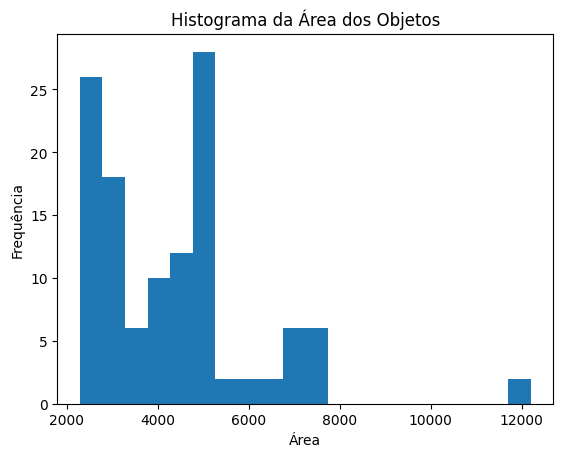

In [22]:
# Plota um histograma da área dos objetos
plt.hist(dataset_geral['area'], bins=20)
plt.xlabel('Área')
plt.ylabel('Frequência')
plt.title('Histograma da Área dos Objetos')
plt.show()

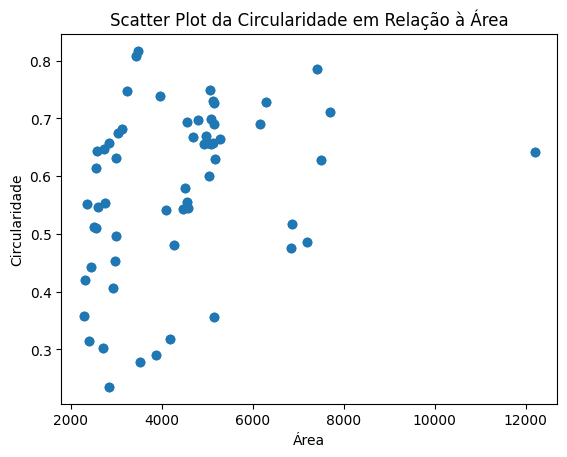

In [23]:
# Plota um scatter plot da circularidade em relação à área
plt.scatter(dataset_geral['area'], dataset_geral['circularity'])
plt.xlabel('Área')
plt.ylabel('Circularidade')
plt.title('Scatter Plot da Circularidade em Relação à Área')
plt.show()

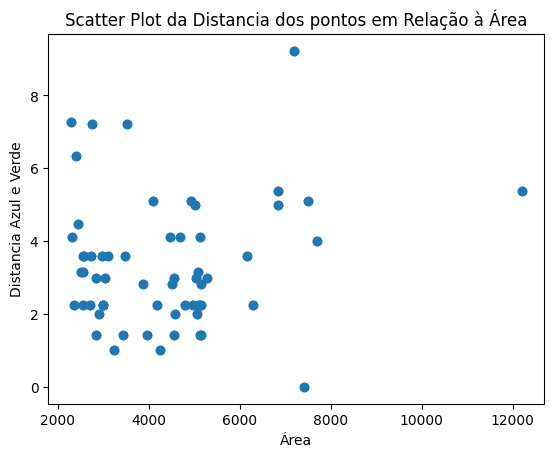

In [24]:
# Plota um scatter plot da circularidade em relação à distancia entre os pontos verde e azul
plt.scatter(dataset_geral['area'], dataset_geral['distance_green_blue'])
plt.xlabel('Área')
plt.ylabel('Distancia Azul e Verde')
plt.title('Scatter Plot da Distancia dos pontos em Relação à Área')
plt.show()

In [25]:
# Filtra os objetos com área acima de um limiar
limiar_area = 5000
objetos_grandes = dataset_geral[dataset_geral['area'] > limiar_area]
print(f"\nNúmero de objetos com área acima de {limiar_area}: {len(objetos_grandes)}")


Número de objetos com área acima de 5000: 42


In [26]:
# Calcula a média da distância entre as cores verde e azul
media_dist_green_blue = dataset_geral['distance_green_blue'].mean()
print(f"\nMédia da distância entre os pontos verde e azul: {media_dist_green_blue}")


Média da distância entre os pontos verde e azul: 3.330123862808523


In [27]:
# Calcula a média da distância entre as cores vermelho e azul
media_dist_red_gree = dataset_geral['distance_red_green'].mean()
print(f"\nMédia da distância entre os pontos vermelho e verde: {media_dist_red_gree}")


Média da distância entre os pontos vermelho e verde: 4.408122579627634


In [28]:
# Calcula a média da distância entre as cores vermelho e verde
media_dist_red_blue = dataset_geral['distance_red_blue'].mean()
print(f"\nMédia da distância entre os pontos vermelho e azul: {media_dist_red_blue}")


Média da distância entre os pontos vermelho e azul: 3.9262872310265635


In [29]:
# Calcula a correlação entre as colunas 'radius' e 'circularity'
correlacao_radius_circularity = dataset_geral['radius'].corr(dataset_geral['circularity'])
print(f"\nCorrelação entre radius e circularity: {correlacao_radius_circularity}")


Correlação entre radius e circularity: 0.09078189691965358


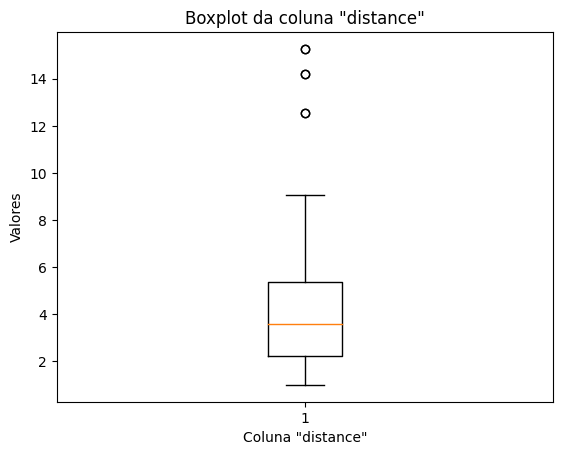

In [30]:
# Acesse a coluna "distance" do DataFrame
coluna_distance = dataset_geral['distance_red_green']

# Crie um boxplot da coluna "distance"
plt.boxplot(coluna_distance)

# Adicione rótulos e título ao gráfico
plt.xlabel('Coluna "distance"')
plt.ylabel('Valores')
plt.title('Boxplot da coluna "distance"')

# Exiba o gráfico
plt.show()

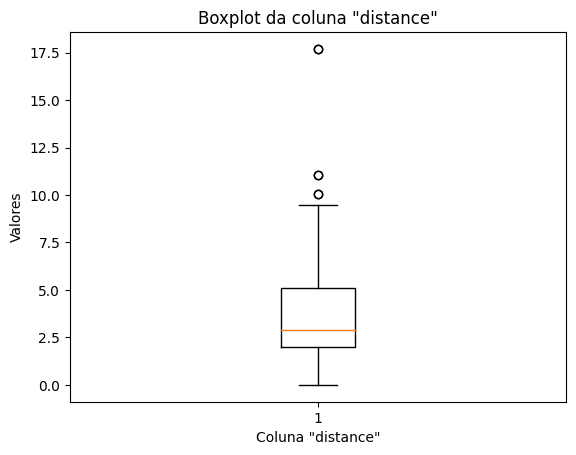

In [31]:
# Acesse a coluna "distance" do DataFrame
coluna_distance = dataset_geral['distance_red_blue']

# Crie um boxplot da coluna "distance"
plt.boxplot(coluna_distance)

# Adicione rótulos e título ao gráfico
plt.xlabel('Coluna "distance"')
plt.ylabel('Valores')
plt.title('Boxplot da coluna "distance"')

# Exiba o gráfico
plt.show()

<ipython-input-33-d81503fba41a>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = dataset_geral.corr()


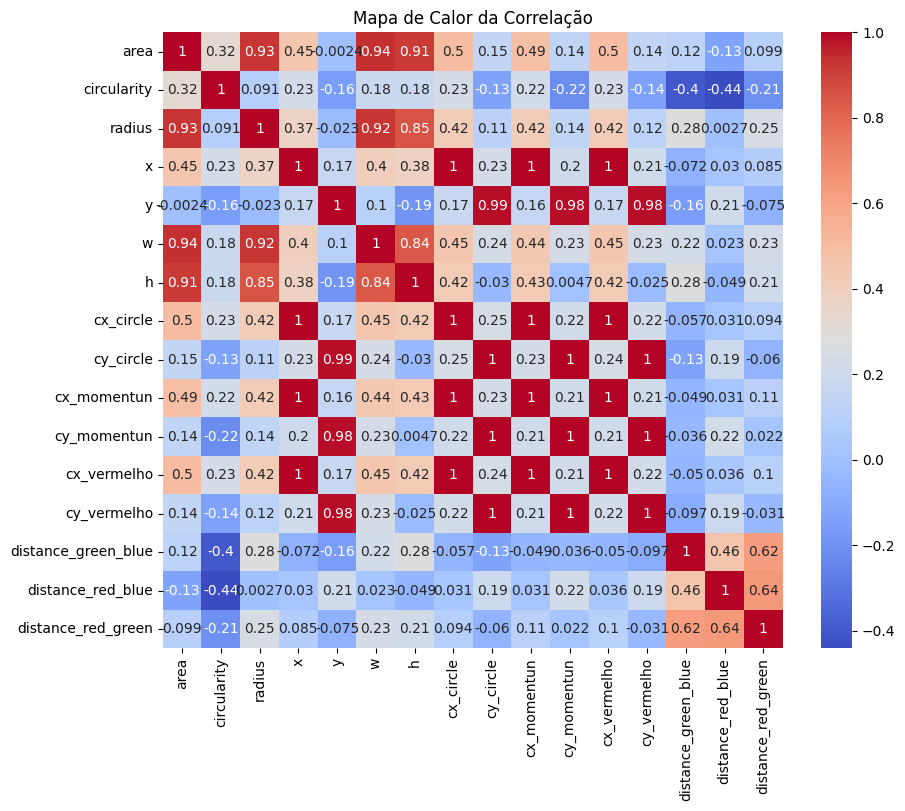

In [33]:
# Calcula a matriz de correlação entre as colunas numéricas do dataset
correlation_matrix = dataset_geral.corr()

# Plota o mapa de calor
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Mapa de Calor da Correlação')
plt.show()